In [1]:
import os
import sys
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import einops
import wandb
import plotly.express as px
from pathlib import Path
import itertools
import random
from IPython.display import display
import wandb
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
from typing import Union, Optional, Tuple, Callable, Dict
import typeguard
from functools import partial
import copy
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
import pandas as pd
import torch
import matplotlib.pyplot as plt

import circuits.eval_sae_as_classifier as eval_sae
import circuits.analysis as analysis
import circuits.eval_board_reconstruction as eval_board_reconstruction
import circuits.get_eval_results as get_eval_results
import circuits.f1_analysis as f1_analysis
import circuits.utils as utils
import circuits.pipeline_config as pipeline_config
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, AutoEncoderNew
import common
import chess_utils
#from plotly_utils import imshow
#from neel_plotly import scatter, line



device = t.device('cuda' if t.cuda.is_available() else 'cpu')
import pickle
with open('meta.pkl', 'rb') as picklefile:
    meta = pickle.load(picklefile)

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
autoencoder = common.load_autoencoder(device)
model = common.load_model(device)
train_dataset = common.get_dataset(device)

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading statistics aggregation dataset


In [3]:
encoded_inputs_tensor = t.stack([t.tensor(x) for x in train_dataset['encoded_inputs']]).to(device)
is_check = train_dataset['board_to_check_state'].squeeze(-1)

In [4]:

max_sae_activations = []
def get_activation(name):
    def hook(model, input, output):
        encoded_activations = autoencoder.encode(output[0]) # batch_size x len_seq x n_features_sae
        collapsed = (encoded_activations.max(dim=0).values.max(dim=0).values)
        max_sae_activations.append(collapsed.unsqueeze(0))
    return hook

t.set_grad_enabled(False)
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))
num_batches = 100
batch_size = len(encoded_inputs_tensor) // num_batches
if device == 'cpu':
    num_batches = 1
    batch_size = 1
    
for i in range(num_batches):
    model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size])
    t.cuda.empty_cache()
activation_handle.remove()


In [5]:
max_activations = t.concat(max_sae_activations).max(dim=0).values

In [6]:
aggregation_results = common.get_aggregation_results(1000)
formatted_results = common.get_formatted_results(aggregation_results)
features_for_check_state = common.get_true_feature_indices(formatted_results, "board_to_check_state")
features_for_check_state = features_for_check_state.to(device)

In [7]:
relevant_sae_activations = []
def get_activation(name, relevant_features):
    def hook(model, input, output):
        encoded_activations = autoencoder.encode(output[0]) # batch_size x len_seq x n_features_sae
        relevant_sae_activations.append(encoded_activations[:, :, relevant_features])
    return hook

t.set_grad_enabled(False)
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}", features_for_check_state))
num_batches = 100
batch_size = len(encoded_inputs_tensor) // num_batches
if device == 'cpu':
    num_batches = 1
    batch_size = 1
for i in range(num_batches):
    model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size])
    t.cuda.empty_cache()
activation_handle.remove()

In [8]:
all_relevant_sae_activations = t.concat(relevant_sae_activations, dim=0)
is_this_a_dot = (encoded_inputs_tensor == meta['stoi']['.']).to(device)

Below we calculate the probability of board being in check conditioned on each feature being activated
Most of them are 1, as expected, but not all! This could be because we're only using training data? 
Question for Adam: This is weird right?
threshold = 0.2

In [9]:
threshold = 0.2
activated_cases = t.where(all_relevant_sae_activations > threshold * max_activations[features_for_check_state], 1, 0)
activated_cases *= is_this_a_dot.unsqueeze(2)
(is_check.squeeze(-1) * activated_cases).sum(dim=0).sum(dim=0)/activated_cases.sum(dim=0).sum(dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000], device='cuda:0')

Hypothesis #1: We can boost the logit for K by increasing activation of these features


In [10]:
is_check.unique()

tensor([0, 1], device='cuda:0', dtype=torch.int8)

In [11]:
def apply_is_a_dot_and_average(input, is_in_check=False):
    normalization_tensor = is_this_a_dot.unsqueeze(2) * ((t.tensor(1.0, device=device) - is_check.squeeze(-1)) if not is_in_check else is_check.squeeze(-1))
    if is_in_check:
        return (input * normalization_tensor).sum(dim=0).sum(dim=0)/normalization_tensor.sum(dim=0).sum(dim=0)
    else:
        return (input * normalization_tensor).sum(dim=0).sum(dim=0)/normalization_tensor.sum(dim=0).sum(dim=0)



def intervene_activation(name, feature_index_list, strength):
    def hook(model, input, output):
        
        output_activations = output[0] # batch_size x len_seq x n_features_residual
        encoded_activations = autoencoder.encode(output_activations) # batch_size x len_seq x n_features_sae
        reconstruction_error = output_activations - autoencoder.decode(encoded_activations)
        encoded_activations[:, :, feature_index_list] = strength * max_activations[feature_index_list]
        output_activations = autoencoder.decode(encoded_activations) + reconstruction_error
        return (output_activations, output[1])
    return hook

def get_baseline_logits():
    num_batches = 100
    batch_size = len(encoded_inputs_tensor) // num_batches
    baseline_logits_list = []
    intervened_logits_list = []
    for i in range(num_batches):
        baseline_logits = model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size]).logits
        baseline_logits_list.append(baseline_logits)
        t.cuda.empty_cache()
    combined_baseline_logits = t.concat(baseline_logits_list, dim=0)
    averaged_baseline_logits_not_check = apply_is_a_dot_and_average(combined_baseline_logits, is_in_check=False)
    averaged_baseline_logits_check = apply_is_a_dot_and_average(combined_baseline_logits, is_in_check=True)
    
    return averaged_baseline_logits_check, averaged_baseline_logits_not_check

def get_intervened_logits(feature_list, strength):
    num_batches = 100
    batch_size = len(encoded_inputs_tensor) // num_batches
    intervened_logits_list = []
    for i in range(num_batches):
        activation_handle = model.transformer.h[5].register_forward_hook(intervene_activation(f"resid_stream_{5}", feature_list, strength))
        intervened_logits = model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size]).logits
        intervened_logits_list.append(intervened_logits)
        activation_handle.remove()
        t.cuda.empty_cache()
    combined_intervened_logits = t.concat(intervened_logits_list, dim=0)
    averaged_intervened_logits_not_check = apply_is_a_dot_and_average(combined_intervened_logits, is_in_check=False)
    averaged_intervened_logits_check = apply_is_a_dot_and_average(combined_intervened_logits, is_in_check=True)
    
    return averaged_intervened_logits_check, averaged_intervened_logits_not_check



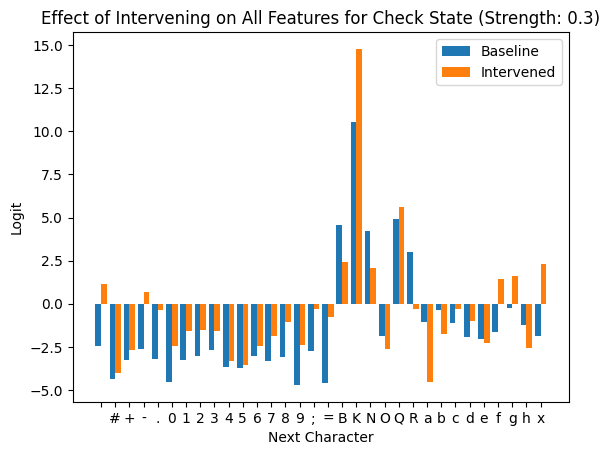

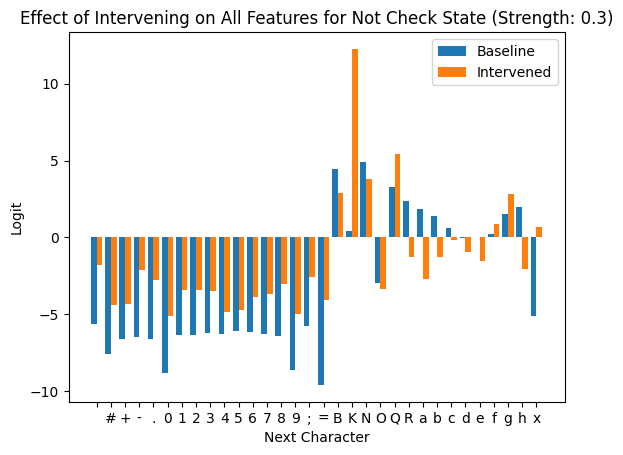

In [12]:
example_strength = 0.3
averaged_baseline_logits_check, averaged_baseline_logits_not_check = get_baseline_logits()
averaged_intervened_logits_check, averaged_intervened_logits_not_check = get_intervened_logits(features_for_check_state, example_strength)
averaged_diff_logits_check = averaged_intervened_logits_check - averaged_baseline_logits_check
averaged_diff_logits_not_check = averaged_intervened_logits_not_check - averaged_baseline_logits_not_check
X = [meta['itos'][i] for i in range(len(averaged_baseline_logits_check.cpu().numpy()))]
y = averaged_baseline_logits_check.cpu().numpy()
z = averaged_intervened_logits_check.cpu().numpy()
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, y, 0.4, label = 'Baseline') 
plt.bar(X_axis + 0.2, z, 0.4, label = 'Intervened') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Next Character") 
plt.ylabel("Logit") 
plt.title(f"Effect of Intervening on All Features for Check State (Strength: {example_strength})") 
plt.legend() 
plt.savefig(f'plots/bar_chart_intervention_check_{example_strength}.png')
plt.show() 

y = averaged_baseline_logits_not_check.cpu().numpy()
z = averaged_intervened_logits_not_check.cpu().numpy()
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, y, 0.4, label = 'Baseline') 
plt.bar(X_axis + 0.2, z, 0.4, label = 'Intervened') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Next Character") 
plt.ylabel("Logit") 
plt.title(f"Effect of Intervening on All Features for Not Check State (Strength: {example_strength})") 
plt.legend() 
plt.savefig(f'plots/bar_chart_intervention_not_check_{example_strength}.png')
plt.show() 


In [13]:
# Let's try to sweep over different strengths and perhaps separate out different features
intervened_dict_path = 'data/averaged_intervened_logits_dict.pt'

if os.path.exists(intervened_dict_path):
    averaged_intervened_logits_dict = t.load(intervened_dict_path)
else:
    averaged_intervened_logits_dict = {}

for strength in np.linspace(0, 1, 11):
    for feature_index in features_for_check_state:
        feature_index = feature_index.item()
        print(feature_index, strength)
        if (feature_index, strength, True) in averaged_intervened_logits_dict.keys():
            print('here')
            continue
        averaged_intervened_logits_check, averaged_intervened_logits_not_check = get_intervened_logits([feature_index], strength)
        t.cuda.empty_cache()
        averaged_intervened_logits_dict[(feature_index, strength, True)] = averaged_intervened_logits_check
        averaged_intervened_logits_dict[(feature_index, strength, False)] = averaged_intervened_logits_not_check

        t.save(averaged_intervened_logits_dict, intervened_dict_path)
    

167 0.0
here
228 0.0
here
410 0.0
here
614 0.0
here
706 0.0
here
746 0.0
here
765 0.0
here
1218 0.0
here
1396 0.0
here
1610 0.0
here
1673 0.0
here
1810 0.0
here
1858 0.0
here
1878 0.0
here
1969 0.0
here
2048 0.0
here
2252 0.0
here
2303 0.0
here
2381 0.0
here
2388 0.0
here
2533 0.0
here
2595 0.0
here
2794 0.0
here
2960 0.0
here
3133 0.0
here
3168 0.0
here
3240 0.0
here
3517 0.0
here
3814 0.0
here
3911 0.0
here
167 0.1
here
228 0.1
here
410 0.1
here
614 0.1
here
706 0.1
here
746 0.1
here
765 0.1
here
1218 0.1
here
1396 0.1
here
1610 0.1
here
1673 0.1
here
1810 0.1
here
1858 0.1
here
1878 0.1
here
1969 0.1
here
2048 0.1
here
2252 0.1
here
2303 0.1
here
2381 0.1
here
2388 0.1
here
2533 0.1
here
2595 0.1
here
2794 0.1
here
2960 0.1
here
3133 0.1
here
3168 0.1
here
3240 0.1
here
3517 0.1
here
3814 0.1
here
3911 0.1
here
167 0.2
here
228 0.2
here
410 0.2
here
614 0.2
here
706 0.2
here
746 0.2
here
765 0.2
here
1218 0.2
here
1396 0.2
here
1610 0.2
here
1673 0.2
here
1810 0.2
here
1858 0.2
here

In [14]:
intervened_df = pd.DataFrame()
for key, value in averaged_intervened_logits_dict.items():
    logit_dict = {f'logit_{meta["itos"][i]}': value[i].item() for i in range(len(value))}
    intervened_df = pd.concat([intervened_df, pd.DataFrame(dict({'feature_index': key[0], 'is_check': key[2]}, **logit_dict), index=[key[1]])])

intervened_df.reset_index(inplace=True)
intervened_df.rename(columns={'index': 'strength'}, inplace=True)
intervened_df.set_index(['feature_index', 'strength', 'is_check'], inplace=True)
intervened_df.head()

logit_    logit_#   logit_+   logit_-  \
feature_index strength is_check                                           
167           0.0      True     -2.683596 -3.951298 -3.039606 -2.710600   
                       False    -5.723537 -7.556266 -6.519949 -6.597851   
228           0.0      True     -2.691607 -3.929584 -3.140400 -2.740156   
                       False    -5.636428 -7.562414 -6.442356 -6.572454   
410           0.0      True     -2.484828 -3.736679 -2.892532 -2.469106   

                                  logit_.   logit_0   logit_1   logit_2  \
feature_index strength is_check                                           
167           0.0      True     -3.224828 -4.395597 -3.377394 -3.091147   
                       False    -6.698700 -8.782581 -6.368092 -6.321313   
228           0.0      True     -3.299101 -4.404761 -3.350670 -3.099429   
                       False    -6.667191 -8.735865 -6.301582 -6.216856   
410           0.0      True     -3.027065 -4.170291 -3.153577 -2.885472   

                                  logit_3   logit_4  ...   logit_R   logit_a  \
feature_index strength is_check                      ...                       
167           0.0      True     -2.803004 -3.711881  ...  3.266183 -1.219535   
                       False    -6.188509 -6.314929  ...  2.346662  1.933328   
228           0.0      True     -2.803832 -3.864244  ...  3.391880 -1.344585   
                       False    -6.052803 -6.264400  ...  2.330369  1.929301   
410           0.0      True     -2.631278 -3.689408  ...  3.271770 -1.518787   

                                  logit_b   logit_c   logit_d   logit_e  \
feature_index strength is_check                                           
167           0.0      True     -0.687900 -0.728352 -2.172644 -2.299822   
                       False     1.382709  0.923160 -0.223522 -0.040869   
228           0.0      True     -0.732005 -0.409713 -2.715236 -2.515326   
                       False     1.346211  1.068186 -0.490372 -0.130994   
410           0.0      True     -0.916871 -0.341970 -2.685489 -2.489460   

                                  logit_f   logit_g   logit_h   logit_x  
feature_index strength is_check                                          
167           0.0      True     -2.106352 -0.114246 -1.172750 -2.120093  
                       False    -0.180509  1.714292  2.014421 -5.197377  
228           0.0      True     -2.527733 -0.118022 -1.284286 -2.239593  
                       False    -0.358645  1.778693  1.847137 -5.159864  
410           0.0      True     -2.463238 -0.273662 -1.603672 -2.010892  

[5 rows x 32 columns]

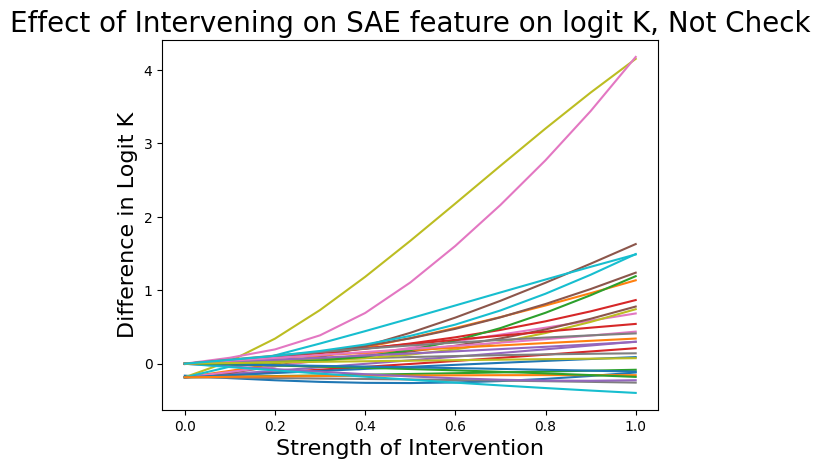

In [15]:
use_only_check = False
if use_only_check:
    filtered_df = intervened_df[intervened_df.index.get_level_values('is_check')]
    diff_df = filtered_df - averaged_baseline_logits_check.cpu().numpy()
else:
    filtered_df = intervened_df[intervened_df.index.get_level_values('is_check') == False]
    diff_df = filtered_df - averaged_baseline_logits_not_check.cpu().numpy()
for feature in diff_df.index.get_level_values('feature_index').unique():
    sub_df = diff_df.loc[feature]
    plt.plot(sub_df.index.get_level_values('strength'), sub_df['logit_K'], label=f'Feature {feature}')
plt.title(f"Effect of Intervening on SAE feature on logit K, {'Check' if use_only_check else 'Not Check'}", fontsize=20)
plt.xlabel("Strength of Intervention", fontsize=16)
plt.ylabel("Difference in Logit K", fontsize=16)
plt.savefig(f'plots/logit_diff_K_vs_strength_all_features_{"check" if use_only_check else "not_check"}.png')
plt.show()

In [16]:
intervened_df

logit_    logit_#   logit_+   logit_-  \
feature_index strength is_check                                           
167           0.0      True     -2.683596 -3.951298 -3.039606 -2.710600   
                       False    -5.723537 -7.556266 -6.519949 -6.597851   
228           0.0      True     -2.691607 -3.929584 -3.140400 -2.740156   
                       False    -5.636428 -7.562414 -6.442356 -6.572454   
410           0.0      True     -2.484828 -3.736679 -2.892532 -2.469106   
...                                   ...       ...       ...       ...   
3517          1.0      False    -5.377056 -8.361050 -6.495056 -6.422735   
3814          1.0      True     -2.315115 -4.318912 -3.097383 -2.591089   
                       False    -5.592498 -7.752275 -6.879166 -6.545562   
3911          1.0      True     -0.192160 -2.420581 -2.438807  0.036038   
                       False    -4.949146 -7.124151 -6.718132 -5.699499   

                                  logit_.   logit_0   logit_1   logit_2  \
feature_index strength is_check                                           
167           0.0      True     -3.224828 -4.395597 -3.377394 -3.091147   
                       False    -6.698700 -8.782581 -6.368092 -6.321313   
228           0.0      True     -3.299101 -4.404761 -3.350670 -3.099429   
                       False    -6.667191 -8.735865 -6.301582 -6.216856   
410           0.0      True     -3.027065 -4.170291 -3.153577 -2.885472   
...                                   ...       ...       ...       ...   
3517          1.0      False    -6.663865 -8.892028 -6.318462 -5.968876   
3814          1.0      True     -2.894196 -4.332937 -3.238779 -2.837519   
                       False    -6.481866 -8.743352 -6.439341 -6.301700   
3911          1.0      True     -0.846518 -1.727725 -2.023131 -1.812217   
                       False    -5.826158 -7.886208 -6.185209 -6.012616   

                                  logit_3   logit_4  ...   logit_R   logit_a  \
feature_index strength is_check                      ...                       
167           0.0      True     -2.803004 -3.711881  ...  3.266183 -1.219535   
                       False    -6.188509 -6.314929  ...  2.346662  1.933328   
228           0.0      True     -2.803832 -3.864244  ...  3.391880 -1.344585   
                       False    -6.052803 -6.264400  ...  2.330369  1.929301   
410           0.0      True     -2.631278 -3.689408  ...  3.271770 -1.518787   
...                                   ...       ...  ...       ...       ...   
3517          1.0      False    -6.040406 -6.301421  ...  2.116443  1.666012   
3814          1.0      True     -2.714215 -3.851064  ...  3.796785 -0.745764   
                       False    -6.269280 -6.572740  ...  2.856703  1.664631   
3911          1.0      True     -1.304361 -2.160374  ...  1.773718 -2.552069   
                       False    -5.680731 -5.427529  ...  2.213523  1.024471   

                                  logit_b   logit_c   logit_d   logit_e  \
feature_index strength is_check                                           
167           0.0      True     -0.687900 -0.728352 -2.172644 -2.299822   
                       False     1.382709  0.923160 -0.223522 -0.040869   
228           0.0      True     -0.732005 -0.409713 -2.715236 -2.515326   
                       False     1.346211  1.068186 -0.490372 -0.130994   
410           0.0      True     -0.916871 -0.341970 -2.685489 -2.489460   
...                                   ...       ...       ...       ...   
3517          1.0      False     0.871917 -0.246022 -0.680933 -0.216158   
3814          1.0      True     -0.005338 -0.145649 -2.578605 -2.238467   
                       False     1.618589  1.097382 -0.347629  0.108472   
3911          1.0      True     -1.221721  0.820429 -1.209181 -1.364375   
                       False     0.366275  1.056193 -0.307490 -0.227113   

                                  logit_f   logit_g   logit_h   l

In [17]:
# use_check = True
if not os.path.exists('plots/logit_diff_by_feature_and_strength.png'):
    logit_columns = ['logit_K', 'logit_Q', 'logit_B', 'logit_N', 'logit_R', 'logit_f', 'logit_g', 'logit_h', 'logit_ ']

# Group by feature_index for plotting
    grouped = intervened_df.groupby('feature_index')

    # Create subplots for each feature_index and logit column
    fig, axes = plt.subplots(nrows=len(features_for_check_state), ncols=2, figsize=(10, 4*len(features_for_check_state)))
    row_index = 0
    for feature_index, group in grouped:
        intervened_logits_check = group[group.index.get_level_values('is_check')]
        intervened_logits_not_check = group[group.index.get_level_values('is_check') == False]
        diff_logits_check = intervened_logits_check - averaged_baseline_logits_check.cpu().numpy()
        diff_logits_not_check = intervened_logits_not_check - averaged_baseline_logits_not_check.cpu().numpy()
        for i, logit_column in enumerate(logit_columns):
            ax_true = axes[row_index, 0] 
            ax_false = axes[row_index, 1] 
            
            # Plot the strength vs. difference in logits
            ax_true.plot(diff_logits_check.index.get_level_values('strength'), diff_logits_check[logit_column], marker='o', label=f'{logit_column}')
            ax_false.plot(diff_logits_not_check.index.get_level_values('strength'), diff_logits_not_check[logit_column], marker='o', label=f'{logit_column}')
            ax_true.set_xlabel('Strength')
            ax_true.set_ylabel(f'Difference in logit')
            ax_true.set_title(f'Feature Index: {feature_index} - check')
            ax_false.set_title(f'Feature Index: {feature_index} - not check')
            ax_false.set_xlabel('Strength')
            ax_true.legend()
            ax_false.legend()
        row_index += 1
        plt.tight_layout()
    plt.savefig('plots/logit_diff_by_feature_and_strength.png')
 

tensor([-2.4279, -4.3625, -3.2615, -2.6145, -3.1782, -4.5167, -3.2538, -3.0274,
        -2.6937, -3.6385, -3.6991, -3.0120, -3.3101, -3.0890, -4.7060, -2.7462,
        -4.5954,  4.5672, 10.5238,  4.2050, -1.8883,  4.9222,  3.0157, -1.0424,
        -0.3384, -1.1140, -1.8993, -2.0497, -1.6528, -0.2675, -1.2371, -1.8574],
       device='cuda:0')